Import the libraries and the Dataset

In [ ]:
import pandas as pd 
import numpy as np 

data = pd.read_csv('emails.csv')  
print("Data shape - ", data.shape, "\n") 

# show part of the dataset
data.head()


Data shape -  (171, 3002) 



,Email No.,the,to,ect,and,for,of,a,you,hou,in,on,is,this,enron,i,be,that,will,have,with,your,at,we,s,are,it,by,com,as,from,gas,or,not,me,deal,if,meter,hpl,please,...,bold,catch,performing,accepted,matters,batch,continuing,winning,symbol,offsystem,decisions,produced,ended,greatest,degree,solmonson,imbalances,fall,fear,hate,fight,reallocated,debt,reform,australia,plain,prompt,remains,ifhsc,enhancements,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Email 2,8,13,24,6,6,2,102,1,27,18,21,13,0,1,61,4,2,0,0,2,0,12,9,95,4,3,3,3,12,3,1,21,1,12,0,1,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Email 3,0,0,1,0,0,0,8,0,0,4,2,0,0,0,8,0,0,0,0,0,0,2,0,2,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Email 4,0,5,22,0,5,1,51,2,10,1,5,9,2,0,16,2,0,0,1,1,0,2,1,36,3,1,2,0,2,3,0,10,2,5,2,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Email 5,7,6,17,1,5,2,57,0,9,3,12,2,2,0,30,8,0,0,2,0,0,7,0,19,2,4,2,0,4,1,2,6,0,6,0,0,3,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Use the prediction column to find the spams and hams indexes

In [ ]:
main_data = np.array(data)
print(f"The lnegth of main dataset is : {len(main_data)}")

column_prediction = [row[-1] for row in main_data]
column_prediction = np.array(column_prediction)

spam_indexes = np.nonzero(column_prediction)[0]

ham_indexes = np.where(column_prediction == 0)[0]

len(spam_indexes) , len(ham_indexes)

The lnegth of main dataset is : 5172


(1500, 3672)

Define the rows of the spams and hams emails

In [ ]:
spam_words_count = main_data[spam_indexes , 1:-1]
ham_words_count = main_data[ham_indexes , 1:-1]

len(spam_words_count) , len(ham_words_count)

(1500, 3672)

Define the percent of test and train data

In [ ]:
Vocabulary_size = 3000
Validation_split = 0.25
BAYES_SPLIT = 0.25
NET_SPLIT = 0.25
KNN_SPLIT = 0.25


# test_spam_index = round( len(spam_words_count) * Validation_split )
# test_ham_index = round( len(ham_words_count) * Validation_split )

# test_spam_index , test_ham_index

In [ ]:
validation_spam_count = round(len(spam_words_count) * Validation_split)
bayes_spam_count = round(len(spam_words_count) * BAYES_SPLIT) + validation_spam_count
net_spam_count = round(len(spam_words_count) * NET_SPLIT) + bayes_spam_count
knn_spam_count = round(len(spam_words_count) * KNN_SPLIT) + net_spam_count

validation_ham_count = round(len(ham_words_count) * Validation_split)
bayes_ham_count = round(len(ham_words_count) * BAYES_SPLIT) + validation_ham_count
net_ham_count = round(len(ham_words_count) * NET_SPLIT) + bayes_ham_count
knn_ham_count = round(len(ham_words_count) * KNN_SPLIT) + net_ham_count

Split train and test data

In [ ]:
train_spam = spam_words_count[validation_spam_count:bayes_spam_count]
train_ham = ham_words_count[validation_ham_count:bayes_ham_count]

test_spam = spam_words_count[:validation_spam_count]
test_ham = ham_words_count[:validation_ham_count]

len(train_spam) , len(test_spam) , len(train_ham) , len(test_ham)
# train_spam

(375, 300, 918, 734)

Count probablities of the spam and ham classes

In [ ]:
p_spam = len(train_spam) / (len(train_spam) + len(train_ham))
p_ham = len(train_ham) / (len(train_spam) + len(train_ham))

p_spam , p_ham

(0.2900232018561485, 0.7099767981438515)

Count the numbers of every word in the class

In [ ]:
words_number_spam = np.sum(train_spam.transpose(),1)
words_number_ham = np.sum(train_ham.transpose(),1)

words_number_spam , words_number_ham

(array([1930, 2349, 895, ..., 1, 679, 4], dtype=object),
 array([5417, 4793, 7496, ..., 1, 693, 6], dtype=object))

Count the numbers of all words in every class

In [ ]:
all_words_spam = np.sum(words_number_spam)
all_words_ham = np.sum(words_number_ham)

all_words_spam , all_words_ham

(532105, 914122)

Count probablities of every words 

In [ ]:
import math

p_words_spam = -np.log(( words_number_spam.astype(float) + 1 ) / ( all_words_spam + Vocabulary_size ))
p_words_ham = -np.log (( words_number_ham.astype(float) + 1 ) / ( all_words_ham + Vocabulary_size ))
# p_words_spam = [-(math.log(i)) for i in p_words_spam]
# p_words_ham = [-(math.log(i)) for i in p_words_ham]


p_words_spam , p_words_ham

(array([ 5.62442499,  5.42804766,  6.39227786, ..., 12.49707109,
         6.66812547, 11.58078036]),
 array([ 5.13151376,  5.25387537,  4.80673757, ..., 13.0358486 ,
         7.18652382, 11.78308564]))

Test the model by test dataset

In [ ]:
def predict(x):
  subset_len = len(x)

  p_temp_spam = np.tile(p_words_spam, (subset_len, 1))
  p_temp_ham = np.tile(p_words_ham, (subset_len, 1))

  estimate_spam = p_temp_spam * x
  estimate_spam = np.sum(estimate_spam, 1) + np.log(p_spam)

  estimate_ham = p_temp_ham * x
  estimate_ham = np.sum(estimate_ham, 1) + np.log(p_ham)

  return estimate_ham > estimate_spam

In [ ]:
predict_spam = predict(test_spam)

TP = len(np.nonzero(predict_spam)[0])
FN = len(test_spam) - TP

predict_ham = predict(test_ham)

FP = len(np.nonzero(predict_ham)[0])
TN = len(test_ham) - FP

print("Accuracy: ", (TP+TN) / (TP+TN+FP+FN))
pd.DataFrame([["Spam", TP, FN], ["Ham", FP, TN]], columns=["#", "Predict Spam", "Predict Ham"])

Accuracy:  0.9400386847195358


,#,Predict Spam,Predict Ham
0,Spam,288,12
1,Ham,50,684


Define a neural network model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout

model = Sequential()
model.add(Input(3000))
model.add(Dense(256 , activation="relu"))
model.add(Dense(128 , activation="relu"))
model.add(Dense(1 , activation="sigmoid"))

model.compile( loss="binary_crossentropy" , optimizer="adam" , metrics=["accuracy"])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               768256    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 801,281
Trainable params: 801,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_spam = spam_words_count[bayes_spam_count:net_spam_count]
train_ham = ham_words_count[bayes_ham_count:net_ham_count]

test_spam = spam_words_count[:validation_spam_count]
test_ham = ham_words_count[:validation_ham_count]


X_train = np.concatenate([train_spam,train_ham]).astype('float')
Y_train = np.concatenate([ np.ones(len(train_spam)) , np.zeros(len(train_ham))])

X_test = np.concatenate([test_spam,test_ham]).astype('float')
Y_test = np.concatenate([ np.ones(len(test_spam)) , np.zeros(len(test_ham))])


In [ ]:
history = model.fit( X_train,Y_train , epochs=10 , batch_size=128 , validation_data=(X_test,Y_test))

Epoch 1/10
11/11 [==============================] - 1s 35ms/step - loss: 1.2778 - accuracy: 0.6584 - val_loss: 0.5041 - val_accuracy: 0.8250
Epoch 2/10
11/11 [==============================] - 0s 25ms/step - loss: 0.3969 - accuracy: 0.8073 - val_loss: 0.5101 - val_accuracy: 0.8617
Epoch 3/10
11/11 [==============================] - 0s 20ms/step - loss: 0.2484 - accuracy: 0.9059 - val_loss: 0.4132 - val_accuracy: 0.9023
Epoch 4/10
11/11 [==============================] - 0s 21ms/step - loss: 0.2061 - accuracy: 0.9353 - val_loss: 0.1954 - val_accuracy: 0.9333
Epoch 5/10
11/11 [==============================] - 0s 21ms/step - loss: 0.1399 - accuracy: 0.9499 - val_loss: 0.1453 - val_accuracy: 0.9632
Epoch 6/10
11/11 [==============================] - 0s 20ms/step - loss: 0.0968 - accuracy: 0.9822 - val_loss: 0.1760 - val_accuracy: 0.9536
Epoch 7/10
11/11 [==============================] - 0s 21ms/step - loss: 0.0617 - accuracy: 0.9854 - val_loss: 0.1138 - val_accuracy: 0.9710
Epoch 8/10
11

The accuracy and validation diagrams

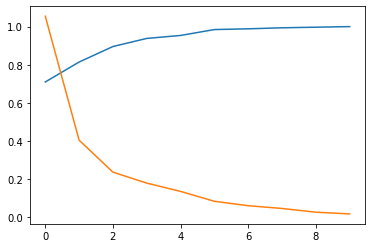

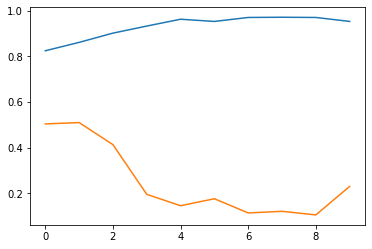

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.show()

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.show()


Define the KNN model

In [ ]:
train_spam = spam_words_count[net_spam_count:knn_spam_count]
train_ham = ham_words_count[net_ham_count:knn_ham_count]

test_spam = spam_words_count[:validation_spam_count]
test_ham = ham_words_count[:validation_ham_count]


X_train = np.concatenate([train_spam,train_ham]).astype('float')
Y_train = np.concatenate([ np.ones(len(train_spam)) , np.zeros(len(train_ham))])

X_test = np.concatenate([test_spam,test_ham]).astype('float')
Y_test = np.concatenate([ np.ones(len(test_spam)) , np.zeros(len(test_ham))])


In [ ]:
k=3

def distance(x1,x2):
  return sum(abs(x1-x2))

def KNN(t):
  D = np.zeros(len(X_train))

  for i , d in enumerate(X_train):
    D[i] = distance(d,t)
  
  temp = np.sort(D)[0:k]
  N = [ np.nonzero(D == i)[0][0] for i in temp]

  if sum(Y_train[N]) > k/2:
    return 1
  else:
    return 0


Test the KNN

In [ ]:
KNN(X_test[10]) , Y_test[10]


(1, 1.0)

Count KNN for a set

In [ ]:
def set_KNN(subset):
  new_set = np.zeros(len(subset))
  for i , d in enumerate(subset):
    new_set[i] = KNN(d)

  return new_set

Accuracy of KNN

In [ ]:
result = set_KNN(X_test)
accuracy = len(np.nonzero( result == Y_test)[0]) / len(Y_test)
accuracy

0.7988394584139265

Define ensemble model by merge 3 models

In [ ]:
def ensemble(x):

  out1 = model.predict(x) #neural netwrok
  out2 = predict(x) #beysian
  out3 = set_KNN(x) #knn

  out1 = np.round(out1)[:,0]
  out2 = [1 if i else 0 for i in out2]
  out3 = np.array(out3)
  output = out1 + out2 + out3 > 1

  return output

Test ensemble

In [ ]:
result = ensemble(X_test)


Accuracy of ensemble model

In [ ]:
accuracy = len(np.nonzero( result == Y_test)[0]) / len(Y_test)
accuracy

0.9468085106382979